# Deep Learning - Text Generation using RNN

## Import required libraries

In [64]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku 
import tensorflow

import pandas as pd
import numpy as np
import string
import time

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [13]:
all_headlines = []
article_df = pd.read_csv('ArticlesMarch2018.csv')
all_headlines.extend(list(article_df.headline.values))
all_headlines = [h for h in all_headlines if h != 'Unknown']
len(all_headlines)

1250

In [14]:
all_headlines[:10]

['Virtual Coins, Real Resources',
 'U.S. Advances Military Plans for North Korea',
 'Mr. Trump and the ‘Very Bad Judge’',
 'To Erase Dissent, China Bans Pooh Bear and ‘N’',
 'Loans Flowed to Kushner Cos. After Visits to the White House',
 'China Envoy Intends To Ease Trade Tensions',
 'President Trump’s Contradictory, and Sometimes False, Comments About Gun Policy to Lawmakers',
 'Classic Letter Puzzle',
 'Silicon Valley Disruption In an Australian School',
 '‘The Assassination of Gianni Versace’ Episode 6: A Nothing Man']

## Dataset preparation

### Dataset cleaning

In [15]:
def clean_text(txt):
    txt = ''.join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode('utf8').decode('ascii', 'ignore')
    return txt

In [16]:
corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['virtual coins real resources',
 'us advances military plans for north korea',
 'mr trump and the very bad judge',
 'to erase dissent china bans pooh bear and n',
 'loans flowed to kushner cos after visits to the white house',
 'china envoy intends to ease trade tensions',
 'president trumps contradictory and sometimes false comments about gun policy to lawmakers',
 'classic letter puzzle',
 'silicon valley disruption in an australian school',
 'the assassination of gianni versace episode 6 a nothing man']

### Generating Sequence of N-gram Tokens

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
token_list = tokenizer.texts_to_sequences(['I am happy to see you here today'])[0]
print(token_list)

[33, 469, 1062, 3, 191, 16, 84, 767]


In [18]:
check=[]

for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    check.append(n_gram_sequence)
    
check

[[33, 469],
 [33, 469, 1062],
 [33, 469, 1062, 3],
 [33, 469, 1062, 3, 191],
 [33, 469, 1062, 3, 191, 16],
 [33, 469, 1062, 3, 191, 16, 84],
 [33, 469, 1062, 3, 191, 16, 84, 767]]

In [21]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    # tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    # convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

In [22]:
inp_sequences, total_words = get_sequence_of_tokens(corpus)

In [25]:
inp_sequences[:10]

[[1119, 1120],
 [1119, 1120, 116],
 [1119, 1120, 116, 1121],
 [31, 1122],
 [31, 1122, 589],
 [31, 1122, 589, 392],
 [31, 1122, 589, 392, 7],
 [31, 1122, 589, 392, 7, 61],
 [31, 1122, 589, 392, 7, 61, 70],
 [117, 10]]

In [26]:
total_words

3582

### Padding the Sequences and obtain Variables : Predictors and Target

In [28]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,
                                             maxlen=max_sequence_len,
                                             padding='pre'))
    
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

In [29]:
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [62]:
np.set_printoptions(threshold=np.inf)
print(label)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [60]:
print(predictors)

[[   0    0    0 ...    0    0 1119]
 [   0    0    0 ...    0 1119 1120]
 [   0    0    0 ... 1119 1120  116]
 ...
 [   0    0    0 ...  979  151  386]
 [   0    0    0 ...    0    0 3581]
 [   0    0    0 ...    0 3581    5]]


In [31]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
len(label[0]) # total words 

3582

In [36]:
max_sequence_len

18

## RNN vs LSTM vs GRU for Text Generation

In [52]:
def create_RNN_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # add input embedding layer
    model.add(Embedding(total_words,
                        32,
                        input_length=input_len))
    
    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.
    
    # add hidden layer 1 - RNN layer
    model.add(SimpleRNN(200))
    
    # add hidden layer 2 - dropout layer 
    model.add(Dropout(0.1))
    
    # add output layer 
    model.add(Dense(total_words,
                    activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
    
    return model

In [53]:
model_RNN = create_RNN_model(max_sequence_len, total_words)
model_RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 17, 32)            114624    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 200)               46600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3582)              719982    
Total params: 881,206
Trainable params: 881,206
Non-trainable params: 0
_________________________________________________________________


In [55]:
def create_LSTM_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
        
    # add input embedding layer
    model.add(Embedding(total_words,
                        32,
                        input_length=input_len))
    
    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.
    
    # add hidden layer 1 - RNN layer
    model.add(LSTM(200))
    
    # add hidden layer 2 - dropout layer 
    model.add(Dropout(0.1))
    
    # add output layer 
    model.add(Dense(total_words,
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
    
    return model

In [56]:
model_LSTM = create_LSTM_model(max_sequence_len, total_words)
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 17, 32)            114624    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               186400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3582)              719982    
Total params: 1,021,006
Trainable params: 1,021,006
Non-trainable params: 0
_________________________________________________________________


In [57]:
def create_GRU_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
        
    # add input embedding layer
    model.add(Embedding(total_words,
                        32,
                        input_length=input_len))
    
    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.
    
    # add hidden layer 1 - RNN layer
    model.add(GRU(200))
    
    # add hidden layer 2 - dropout layer 
    model.add(Dropout(0.1))
    
    # add output layer 
    model.add(Dense(total_words,
                    activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
        
    return model

In [58]:
model_GRU = create_GRU_model(max_sequence_len, total_words)
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 17, 32)            114624    
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               139800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3582)              719982    
Total params: 974,406
Trainable params: 974,406
Non-trainable params: 0
_________________________________________________________________


In [59]:
# setting early_stopping feature to stop early on getting stagnat
early_stopping = EarlyStopping(min_delta=0.01, # minimum amount of change to count as an improvement
                               patience=5, # how many epochs to wait before stopping
                               restore_best_weights=True)

## Fit models

In [65]:
start_time = time.time()
model_RNN.fit(predictors,
              label,
              epochs=200,
              callbacks=[early_stopping])
clear_output(wait=True)
end_time = time.time()

Instructions for updating:
Use tf.cast instead.
Epoch 1/200


2023-11-01 22:23:12.113452: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2
2023-11-01 22:23:12.114557: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


8057/8057 [==============================] - 17s 2ms/sample - loss: 7.6200
Epoch 2/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 7.0833
Epoch 3/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 6.7690
Epoch 4/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 6.3781
Epoch 5/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 5.9408
Epoch 6/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 5.4889
Epoch 7/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 5.0059
Epoch 8/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 4.5022
Epoch 9/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 3.9961
Epoch 10/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 3.5260
Epoch 11/200
8057/8057 [==============================] - 17s 2ms/sample - loss: 3.0889
Epoch 12/200
8057/8057 [=============================

In [66]:
total_time = end_time - start_time
total_time_td = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Total time: {total_time_td}')

Total time: 00:50:55


In [71]:
model_RNN.save('model_RNN')

In [67]:
start_time = time.time()
model_LSTM.fit(predictors,
              label,
              epochs=200,
              callbacks=[early_stopping])
clear_output(wait=True)
end_time = time.time()

Epoch 1/200
8057/8057 [==============================] - 42s 5ms/sample - loss: 7.5890
Epoch 2/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 7.0546
Epoch 3/200
8057/8057 [==============================] - 36s 5ms/sample - loss: 6.8768
Epoch 4/200
8057/8057 [==============================] - 38s 5ms/sample - loss: 6.7059
Epoch 5/200
8057/8057 [==============================] - 38s 5ms/sample - loss: 6.5168
Epoch 6/200
8057/8057 [==============================] - 37s 5ms/sample - loss: 6.3066
Epoch 7/200
8057/8057 [==============================] - 38s 5ms/sample - loss: 6.0659
Epoch 8/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 5.7897
Epoch 9/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 5.5026
Epoch 10/200
8057/8057 [==============================] - 37s 5ms/sample - loss: 5.2161
Epoch 11/200
8057/8057 [==============================] - 38s 5ms/sample - loss: 4.9489
Epoch 12/200
8057/8057 [=================

In [68]:
total_time = end_time - start_time
total_time_td = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Total time: {total_time_td}')

Total time: 02:05:56


In [72]:
model_LSTM.save('model_LSTM')

In [69]:
start_time = time.time()
model_GRU.fit(predictors,
              label,
              epochs=200,
              callbacks=[early_stopping])
clear_output(wait=True)
end_time = time.time()

Epoch 1/200
8057/8057 [==============================] - 34s 4ms/sample - loss: 7.6448
Epoch 2/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 7.1023
Epoch 3/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 6.8710
Epoch 4/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 6.6039
Epoch 5/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 6.2971
Epoch 6/200
8057/8057 [==============================] - 32s 4ms/sample - loss: 5.9382
Epoch 7/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 5.5147
Epoch 8/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 5.0627
Epoch 9/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 4.6027
Epoch 10/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 4.1586
Epoch 11/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 3.7262
Epoch 12/200
8057/8057 [=================

In [70]:
total_time = end_time - start_time
total_time_td = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Total time: {total_time_td}')

Total time: 01:49:00


In [73]:
model_GRU.save('model_GRU')

## Compare models

In [81]:
print(model_RNN.history.history.keys())

dict_keys(['loss'])


In [87]:
loss_RNN = model_RNN.history.history['loss'][-1]
loss_LSTM = model_LSTM.history.history['loss'][-1]
loss_GRU = model_GRU.history.history['loss'][-1]

In [89]:
print(f'RNN : {loss_RNN:.3f}')
print(f'LSTM : {loss_LSTM:.3f}')
print(f'GRU : {loss_GRU:.3f}')

RNN : 0.348
LSTM : 0.262
GRU : 0.283


In [94]:
loss_RNN = model_RNN.history.history['loss']
loss_LSTM = model_LSTM.history.history['loss']
loss_GRU = model_GRU.history.history['loss']

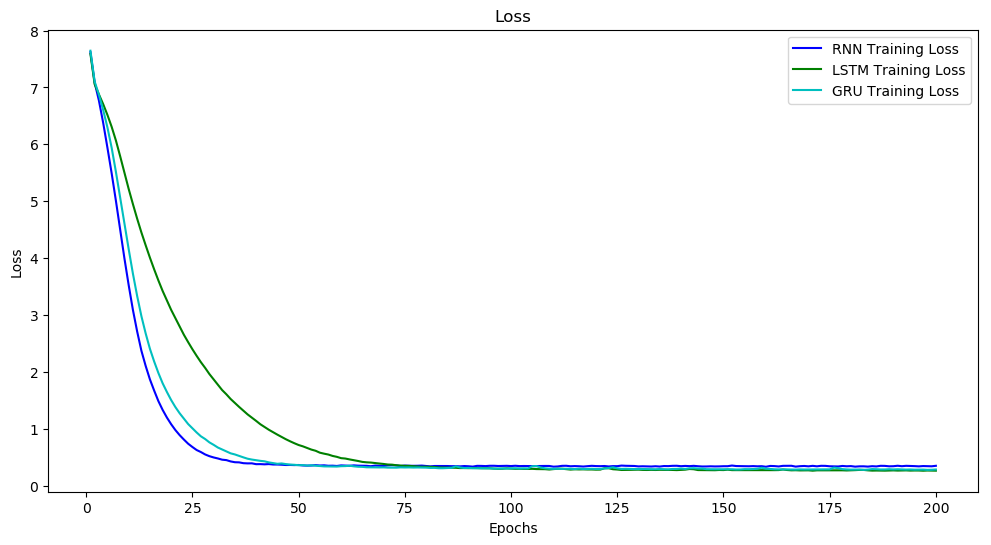

In [95]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_RNN) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_RNN, 'b', label='RNN Training Loss')
plt.plot(epochs, loss_LSTM, 'g', label='LSTM Training Loss')
plt.plot(epochs, loss_GRU, 'c', label='GRU Training Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Generating the text

In [96]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
print (generate_text("jack ", 5, model, max_sequence_len))
print (generate_text("president trump",5, model, max_sequence_len))
print (generate_text("donald", 6, model, max_sequence_len))
print (generate_text("india and china", 2, model, max_sequence_len))
print (generate_text("new york", 4, model, max_sequence_len))
print (generate_text("science and technology", 6, model, max_sequence_len))

In [99]:
print('RNN')
print (generate_text("jack ", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("jack ", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("jack ", 5, model_RNN, max_sequence_len))

RNN
Jack  We Wont Let The Nra


LSTM
Jack  Affordable Tree Is Fake But


GRU
Jack  We Wont Let The Nra


In [100]:
print('RNN')
print (generate_text("president trump", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("president trump", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("president trump", 5, model_RNN, max_sequence_len))

RNN
President Trump Life In Data Misuse Sets


LSTM
President Trump Says Health Care A Doggy


GRU
President Trump Life In Data Misuse Sets


In [101]:
print('RNN')
print (generate_text("india and china", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("india and china", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("india and china", 5, model_RNN, max_sequence_len))

RNN
India And China Battle For Edge In Technology


LSTM
India And China The Real Nationalists In Vietnam


GRU
India And China Battle For Edge In Technology


In [102]:
print('RNN')
print (generate_text("science and technology", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("science and technology", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("science and technology", 5, model_RNN, max_sequence_len))

RNN
Science And Technology Not A Drill 11 Students


LSTM
Science And Technology Have Her Spending Plan To


GRU
Science And Technology Not A Drill 11 Students
